In [ ]:
#downloading the file from drive
import gdown
file_id='1sOkn7vHZBTL3UlF2dQ6IO36RS7RlbEn9'
output_path='capsule_yolo.zip'
gdown.download(id=file_id, output=output_path, quiet=False)
print(f"Downloaded: {output_path}")

Downloading...
From (original): https://drive.google.com/uc?id=1sOkn7vHZBTL3UlF2dQ6IO36RS7RlbEn9
From (redirected): https://drive.google.com/uc?id=1sOkn7vHZBTL3UlF2dQ6IO36RS7RlbEn9&confirm=t&uuid=a6365b6b-5ceb-4646-bb0e-bc953b164071
To: /content/capsule_yolo.zip
100%|██████████| 405M/405M [00:03<00:00, 123MB/s]

Downloaded: capsule_yolo.zip


In [ ]:
import zipfile
#de ziping it
if zipfile.is_zipfile(output_path):
  with zipfile.ZipFile(output_path,'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import shutil
from pathlib import Path
import random
import yaml

In [ ]:
#editing the folders moving 80% of defective smalpes to train
#and fixing the class ID (changing 1 to 0 inside the text file)

dataset_path=Path('/content/capsule_yolo')
training_img=dataset_path/"images"/"train"
training_label=dataset_path/"labels"/"train"
testing_img=dataset_path/"images"/"val"
testing_label=dataset_path/"labels"/"val"

testing_defects=[f for f in testing_img.glob("*.png") if not f.name.startswith("good_")]

if len(testing_defects)>0 :
    print(f"found {len(testing_defects)} defects in 'val'. Moving 80% to 'train'...")
    random.seed(42)
    random.shuffle(testing_defects)

    #keep 20% in val and move 80% to train
    move_count=int(len(testing_defects)*0.8)

    for img_path in testing_defects[:move_count]:
      lable_name=img_path.with_suffix(".txt").name

      #move the image
      shutil.move(img_path,training_img/img_path.name)

      #move label
      src_lbl=testing_label/lable_name
      if src_lbl.exists():
        shutil.move(str(src_lbl),str(training_label/lable_name))

    print('redetribution complete')
else :
  print("defects seem to be already in train")



found 109 defects in 'val'. Moving 80% to 'train'...
redetribution complete


In [ ]:
#fix class ids (change '1' to '0')

def fix_labels(folder):
    count = 0
    for lbl_file in folder.glob("*.txt"):
        with open(lbl_file, 'r') as f:
            lines = f.readlines()

        new_lines = []
        changed = False
        for line in lines:
            parts = line.strip().split()
            if parts and parts[0] != "0": # If class is not 0
                parts[0] = "0"
                new_lines.append(" ".join(parts))
                changed = True
            else:
                new_lines.append(line.strip())

        if changed:
            with open(lbl_file, 'w') as f:
                f.write("\n".join(new_lines))
            count += 1
    return count

fixed_train = fix_labels(training_label)
fixed_val = fix_labels(testing_label)


In [ ]:
#create Data.yaml file

yaml_content = {
    'path': str(dataset_path.absolute()),
    'train': 'images/train',
    'val': 'images/val',
    'names': {0: 'defect'}
}

with open('custom.yaml', 'w') as f:
    yaml.dump(yaml_content, f)

print("\n 'custom.yaml' created.")
print(f"Train Images: {len(list(training_img.glob('*.png')))}")
print(f"Val Images:   {len(list(testing_img.glob('*.png')))}")
print("Ready for training.")


 'custom.yaml' created.
Train Images: 306
Val Images:   45
Ready for training.


In [ ]:
! pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00


In [ ]:
#using yolov8 nano segmentation model since it is the fastes
from ultralytics import YOLO
#uploading the model
model = YOLO('yolov8n-seg.pt')
results=model.train(
    data='custom.yaml',
    epochs=30,
    imgsz=640,
    batch=8,
    name='capsule_experements',
    patience=10,
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=custom.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=capsule_experements2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose

KeyboardInterrupt: 

In [ ]:
from ultralytics import YOLO

# 1. Load the 'Small' model (Better than Nano )
print("Loading YOLOv8-Small Segmentation model...")
model = YOLO('yolov8s-seg.pt')

# 2. Train with "Project Settings"
print("Starting Final Training (20 Epochs)...")
results = model.train(
    data='custom.yaml',
    epochs=20,               # Give it enough time
    patience=20,              # Wait longer before stopping early
    imgsz=640,
    batch=8,                  # Keep 8 (safe for most GPUs)
    name='capsule_final_run', # New folder name

    # Advanced Tweaks for MVTec:
    fliplr=0.0,               # Disable Left-Right Flip (Text on capsules shouldn't be mirrored!)
    mosaic=1.0,               # Keep mosaic on (helps with small objects)
)

print("Final Training Finished.")
print("The best model is saved at: runs/segment/capsule_final_run/weights/best.pt")

Loading YOLOv8-Small Segmentation model...
Starting Final Training (20 Epochs)...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=custom.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=capsule_final_run, nbs=64, nms=False, opset=None, optimize=False, op


image 1/1 /content/capsule_yolo/images/val/poke_020.png: 640x640 1 defect, 583.4ms
Speed: 20.8ms preprocess, 583.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)


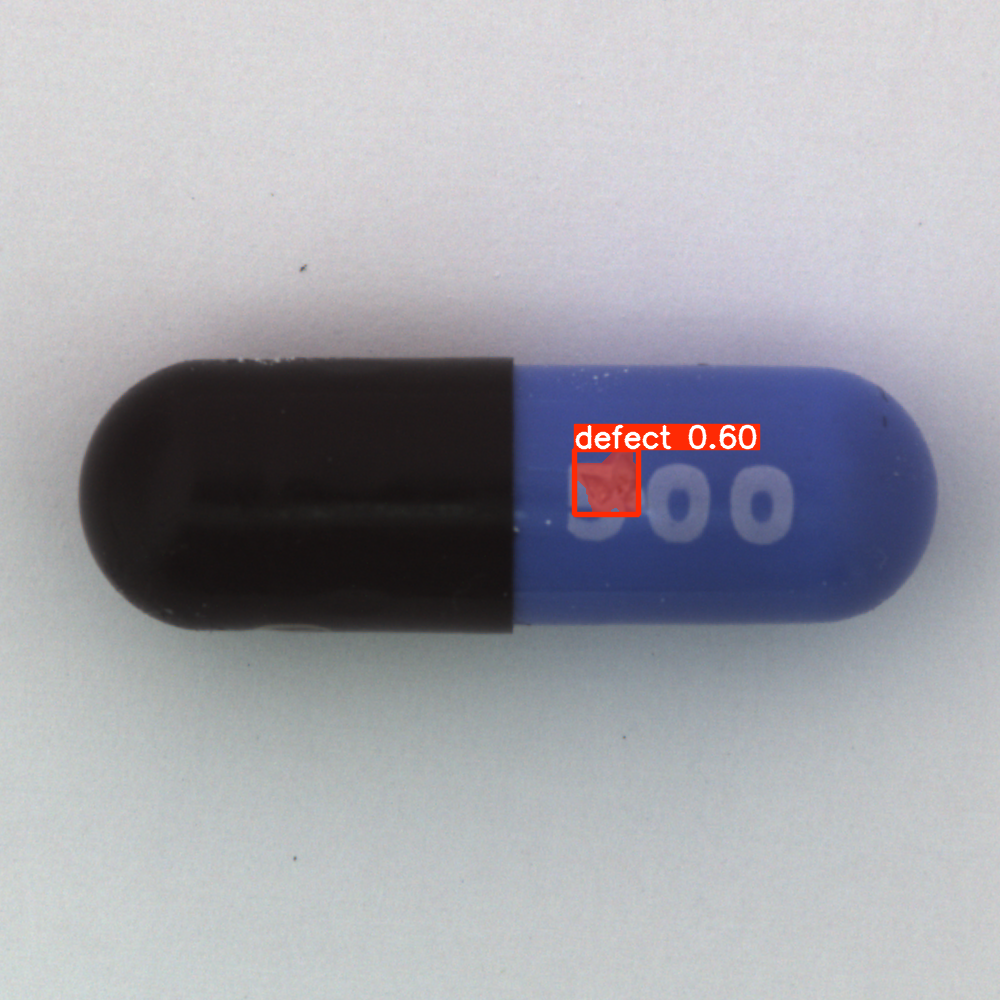

In [ ]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow

# Load the best trained model
model = YOLO('/content/runs/segment/capsule_experements/weights/best.pt')

# Path to an example test image from your validation set
test_image_path = '/content/capsule_yolo/images/val/poke_020.png'

# Perform inference
results = model(test_image_path)

# Process and display results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for display
    cv2_imshow(im_rgb) # Display the image with predictions